In [82]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Funciones generales

In [98]:
def comparacion_imagenes(img1,img2):
    plt.figure(figsize=(15,15))
    
    #Imagen original
    plt.subplot(1,2,1)
    plt.title("Imagen original", color = "red")
    plt.imshow(img1, cmap = "grey")
    plt.axis("off")

    #Imagen reconstruida
    plt.subplot(1,2,2)
    plt.title("Imagen reconstruida", color = "blue")
    plt.imshow(img2, cmap = "grey")
    plt.axis("off")

# Ejercicio 1: Correlación

#### (a) Grafico de dispersion para pixeles vecinos

In [ ]:
def escala_de_grises(path):
    return Image.open(path).convert("L")

def conversion_float(img):
    return np.array(img, dtype = np.float32) / 255.0

#Funcion para formar bloques de pixeles vecinos
def formar_bloques(img):
    X1 = []
    X2 = []
    #Iteracion por filas
    for i in range(len(img)): 
        #En caso que la fila sea un número par, se agregan los pixeles a X1
        if i % 2 == 0: 
            X1.extend(img[i]) 
        else:
            #Caso contrario, se agregan a X2
            X2.extend(img[i])
    return np.vstack([X1, X2]).T #de esta manera, los pixeles vecinos verticalmente quedan en la misma fila

#Gráfico
def grafico_dispersion(X, img, title1, title2):

    _, axes = plt.subplots(1, 2, figsize = (15, 15))

    # Imagen en grises
    axes[0].imshow(img, cmap = "gray")
    axes[0].set_title(f"{title1}")
    axes[0].axis("off")

    # Gráfico de dispersión
    axes[1].scatter(X.T[0], X.T[1], s= 1, alpha = 0.5, color = "darkblue")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(f"{title2}")

    plt.tight_layout()
    plt.show()


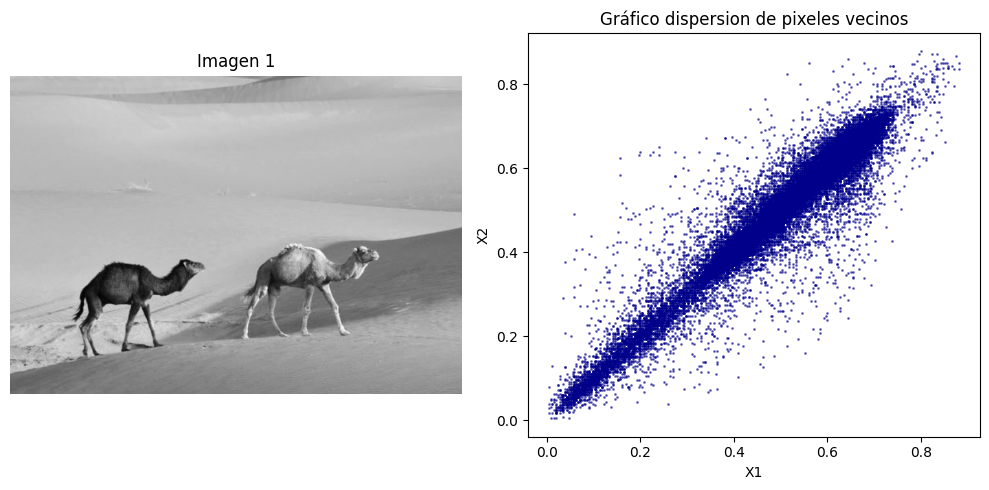

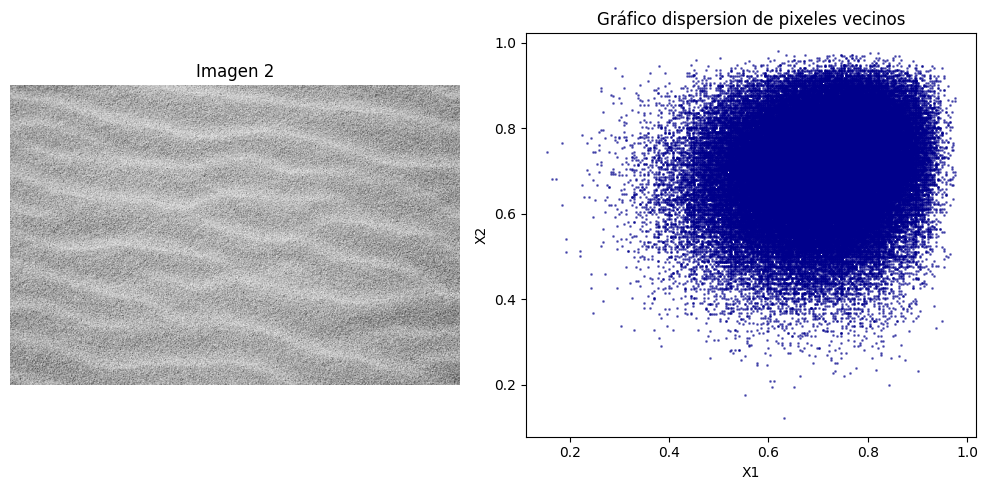

In [84]:
if __name__ == "__main__":
    img1 = escala_de_grises("img_01.jpg")
    img2 = escala_de_grises("img_02.jpg")
    
    #Convertir a float
    img1_float = conversion_float(img1)
    img2_float = conversion_float(img2) # astype(float)

    #Grafico de dispersion para pixeles vecinos
    bloques1 = formar_bloques(img1_float)
    bloques2 = formar_bloques(img2_float)

    grafico_dispersion(bloques1, img1_float, "Imagen 1", "Gráfico dispersion de pixeles vecinos")
    grafico_dispersion(bloques2, img2_float, "Imagen 2", "Gráfico dispersion de pixeles vecinos")
    

#### (b) Estimación del coeficiente de correlación

In [ ]:
def coef_correlacion(X):
    """
    Calculo del coeficiente de correlacion
    """
    return np.corrcoef(X.T[0], X.T[1])[0,1]

In [86]:
if __name__ == "__main__":
    coef_correlacion_img1 = coef_correlacion(bloques1)
    coef_correlacion_img2 = coef_correlacion(bloques2)

    print(f"Coeficiente de correlación Imagen 1: {coef_correlacion_img1}")
    print(f"Coeficiente de correlación Imagen 2: {coef_correlacion_img2}")

#COMPLETAR CONCLUSION

Coeficiente de correlación Imagen 1: 0.9792211339601856
Coeficiente de correlación Imagen 2: 0.1458537355246135


##### Observamos que para la imagen uno, los pixeles vecinos estan altamente correlacionados, lo que significa que al conocer un pixel podemos deducir de el, el valor de su pixel vecino, por lo que hay redundancia. Se puede comprimir con  alta eficiencia y manteniendo la calidad

##### Por otro lado, para la segunda imagen, ocurre el caso contrario. Los pixeles están poco correlacionados, lo que signufica que son independientes, por lo que no se puede deducir el valor de un pixel basandose en su vecino. Esto implica el aumento de bits para comprimir la imagen....

#### (c) Desacoplamiento

In [87]:
def desacoplar(X):
    #Aplicación de la transformacion Y = P^tX
    
    mu_estimado = np.mean(X, axis = 0) #calculo de la media
    #Vector centrado 
    Xc = X - mu_estimado 

    #Cálculo de la covarianza entre pixeles vecinos
    #Cx_estimado = (Xc @ Xc.T)/ (Xc.shape[0] -1)
    Cx_estimado = np.cov(Xc, rowvar = False) #matriz de covarianza estimada
    #Obtención de los autovalores columna
    autovalores, P = np.linalg.eigh(Cx_estimado)
    
    index = np.argsort(autovalores)[::-1] #indices para ordenar autovalores de mayor a menor
    P_ordenado = P[:, index] #autovectores ordenados de mayor a menor segun autovalores
    autovalores = autovalores[index] #autovalores ordenados de mayor a menor

    #Transformacion lineal Y -> vector descorrelacionado
    Y = Xc @ P_ordenado 
    return Y, P_ordenado, Xc, autovalores, mu_estimado

#Xc.shape[1] -1) -> Dividimos por N -1 (usamos el estimador insesgado)
#Xc.shape[1] = numero de columnas = N muestras

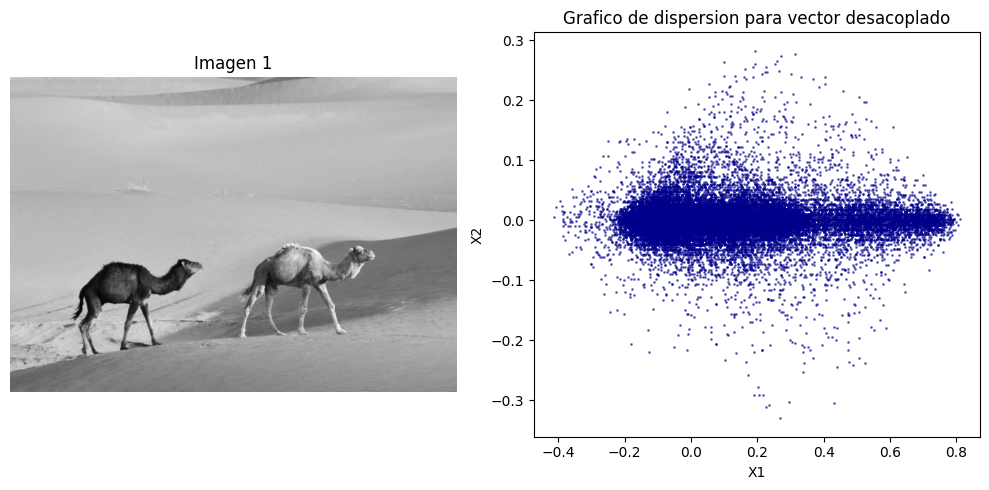

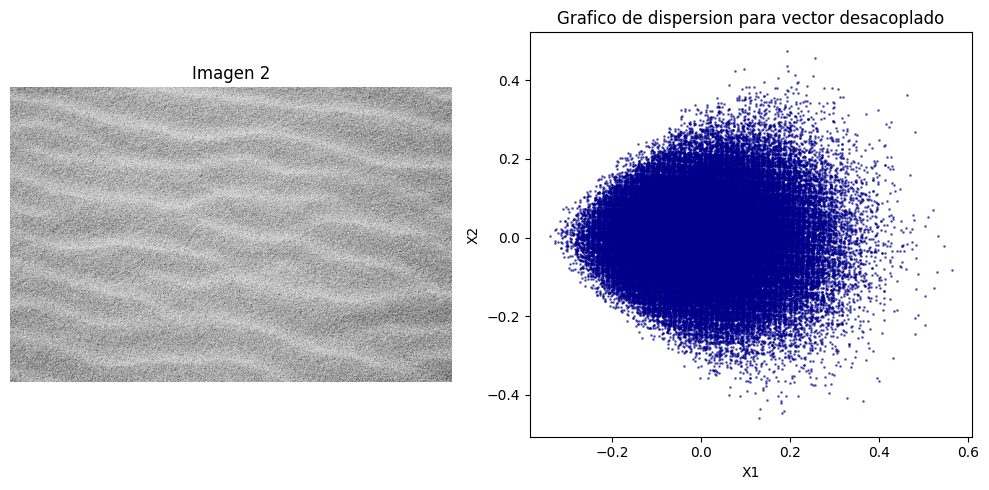

In [88]:
if __name__ == "__main__":
    #Imagen desacoplada
    Y1, _ , _, _, _ = desacoplar(bloques1)
    Y2, _, _, _ , _= desacoplar(bloques2)

    grafico_dispersion(Y1, img1_float, "Imagen 1", "Grafico de dispersion para vector desacoplado")
    grafico_dispersion(Y2, img2_float, "Imagen 2", "Grafico de dispersion para vector desacoplado")

##### Tras el proceso de descorrelación mediante PCA, en ambos casos, se logra el desacoplamiento de las variables, lo cual se evidencia en la ausencia de la nube inclinada. 
##### No obstante, se puede observar facilmente que, en la primera imagen, la varianza queda praticamente concentrada en la componente horizontal, lo que indica que originalmente existía una correlación más fuerte entre los píxeles vecinos. En la segunda fotografia, pese a que también predomina la componente horizontal, la dispersión es mayor en la dirección contraria al caso anterior, reflejando que la correlación inicial entre píxeles era menor.

# Ejercicio 2: Compresión

#### (a) Funcion de PCA

In [89]:
def pca_transform(Xi, k):
    #Yk = Pk ^t Xc
    _, Pi_decreciente, Xc, autovaloresi, mu_estimadoi = desacoplar(Xi)
    
    #Matriz de proyección a k dimensiones
    Pk = Pi_decreciente[:, :k]  #matriz de proyección a k dimensiones
    Yk = Xc @ Pk #proyección a k dimensiones

    return Yk, Pk, autovaloresi, mu_estimadoi

#### (b) Aplicación de PCA

In [90]:
def bloques_8x8(img):
    #recorte de la imagen a un multiplo de ocho
    filas_recortadas = img.shape[0] - (img.shape[0] % 8) #recorto a filas multiplo de ocho. El mod me da el sobrante
    columnas_recortadas = img.shape[1] - (img.shape[1] % 8) #recorto a columnas multiplo de ocho
    img = img[:filas_recortadas, :columnas_recortadas]

    vectores_xi = []
    for i in range(0, img.shape[0], 8): #shape[0] = filas
        for j in range(0, img.shape[1], 8): #shape[1] = columnas
            bloque = img[i:i+8, j:j+8] #agarramos el bloque 8x8
            vectores_xi.append(bloque.flatten()) #convertimos el bloque en un vector de 64x1
    
    return np.vstack(vectores_xi).T

def k_valores(S, m):
    k = int((1-(S/100))*m)
    return k



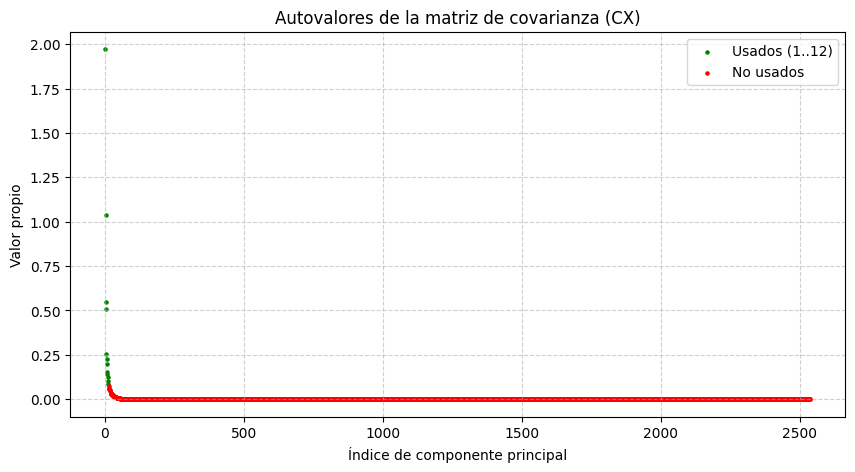

In [97]:
if __name__ == "__main__":
    img3 = escala_de_grises("img_03.jpg")
    #Convertir a float
    img3_float = conversion_float(img3)

    #Aplicacion de PCA por bloque
    k = k_valores(80, 64)
    bloques = bloques_8x8(img3_float)
    Yk, Pk, autovaloresi, mu_estimadoi = pca_transform(bloques, k)

    # Graficar autovalores
    plt.figure(figsize=(10,5))
    plt.scatter(range(1, k+1), autovaloresi[:k], color='green', s=5, label=f"Usados (1..{k})")
    plt.scatter(range(k+1, len(autovaloresi)+1), autovaloresi[k:], color='red', s=5, label="No usados")

    #plt.axvline(x=k, color="gray", linestyle="--", label=f"Se conserva k={k}")
    plt.xlabel("Índice de componente principal")
    plt.ylabel("Valor propio")
    plt.title("Autovalores de la matriz de covarianza (CX)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# Ejercicio 3: Descompresión

#### (a) Regeneracion

In [92]:
def descompresion(Pk,mu_x, Yk):
    #Xk = PkYk + mux
    return Yk @ Pk.T + mu_x

def reconstruccion(X,img):
    filas = (img.shape[0] - (img.shape[0] % 8)) // 8
    columnas = (img.shape[1] - (img.shape[1] % 8))// 8
    
    #Creacion de una matriz de 0's = imagen en blanco 
    matriz_reconstruccion = np.zeros((filas * 8, columnas * 8), dtype=float)
    k = 0
    for i in range(filas):
        for j in range(columnas):
            bloque = X[:,k].reshape((8,8))
            matriz_reconstruccion[i*8: (i+1)*8, j*8: (j+1)*8] = bloque
            k += 1
    return matriz_reconstruccion

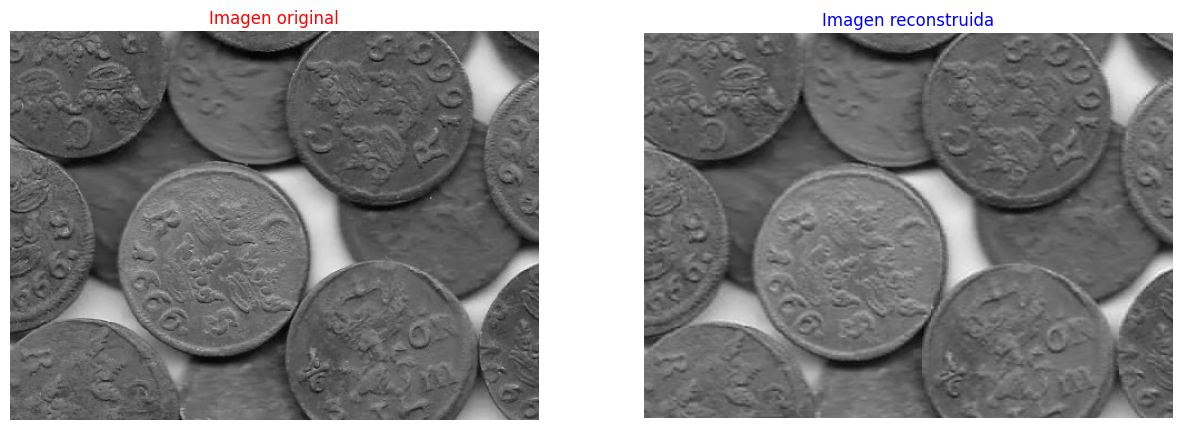

In [99]:
if __name__ == "__main__":
    X_reconstruido = descompresion(Pk,mu_estimadoi,Yk)
    imagen_reconstruida = reconstruccion(X_reconstruido,img3_float)

comparacion_imagenes(img3_float, imagen_reconstruida)

# Ejercicio 4: Medidas de desempeño

### (a) Cálculo del Medium Square Error (MSE)

In [ ]:

def calcula_MSE(img, n):
    Yk_vectores, Pk_matrices, _, _, mu_x_vectores = pca_transform(img, k)
    img_rec = []
    Nw = img.shape[1]
    Nh = img.shape[0]

    for i in range(len(Yk_vectores)):
        X = descompresion(Pk_matrices[i], mu_x_vectores[i], Yk_vectores[i])
        
    


       
        



### (b) Casos para S

In [ ]:
if __name__ == "__main__":
    img4 = escala_de_grises("img_04.jpg")
    #Convertir a float
    img4_float = conversion_float(img4)

    n = 19

    S = [75,80,85,90,95]
    for s in S:
        comparacion_imagenes(img4_float, img2)
